In [3]:
import torch,os
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

from torchvision.io import read_image
from pathlib import Path
from PIL import Image

from xml.etree import ElementTree as ET
from torch.utils.data import Dataset,DataLoader,random_split

import torchvision.transforms.functional as F
import numpy as np

import cv2
import matplotlib.pyplot as plt

In [4]:
class CustomDataset(Dataset):
    def __init__(self,root_dir, xml_file,color_file, transform=None ) -> None:
        self.root_dir = root_dir
        self.color_mapping = self.load_color_mapping(color_file)
        self.data = self.parse_xml(xml_file)
        self.transform = transform

    def load_color_mapping(self,color_file):
        color_mapping = {}
        with open(color_file,'r') as file:
            for line in file:
                color_id, color_name = line.strip().split(' ',1)
                color_mapping[int(color_id)-1] = color_name
        return color_mapping

    def parse_xml(self, xml_file):
        data = []
        with open(xml_file,'r') as file:
            tree = ET.fromstring(file.read())
            tree = ET.ElementTree(tree)
            root = tree.getroot()
            for item in root.findall('.//Item'):
                image_name = item.get('imageName')
                color_id = int(item.get('colorID'))
                data.append((image_name,color_id))
        return data

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        img_name, color_id = self.data[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, color_id-1, img_name




In [5]:
# FOLDER_DATASET = "/home/kk/Desktop/usama/datasets/VeRi"
FOLDER_DATASET = "/mnt/linux/stallionSpace/itu/semester3/thesis1/datasets/VeRi"
FOLDER_TARGET = "/mnt/linux/stallionSpace/itu/semester3/thesis1/datasets/VeRi_mask"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


test_dataset = CustomDataset(FOLDER_DATASET+"/image_test",FOLDER_DATASET+"/test_label.xml",FOLDER_DATASET+"/list_color.txt")

In [6]:
weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

In [7]:
for car_idx in range(len(test_dataset)):
    car =test_dataset[car_idx][0] 
    car_list = [car]
    batch = torch.stack([transforms(d) for d in car_list])
    output = model(batch)['out']

    normalized_masks = torch.nn.functional.softmax(output, dim=1)

    mask = normalized_masks[0,sem_class_to_idx['car']]  
    mask_img = mask.detach()
    mask_img = F.to_pil_image(mask_img)
    
    mask_img_np = np.asarray(mask_img)
    car_mask = np.zeros_like(mask_img_np)
    car_mask[mask_img_np > 100] = 255
    break


In [8]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [9]:
car = np.asarray(car)
only_car = np.zeros_like(car)
only_car[car_mask > 0] = car[car_mask > 0]
only_car_resized = image_resize(only_car,90)


In [10]:
road = cv2.imread("road.jpeg")
road = cv2.cvtColor(road,cv2.COLOR_BGR2RGB)
road_mask = cv2.imread("road_mask.png")

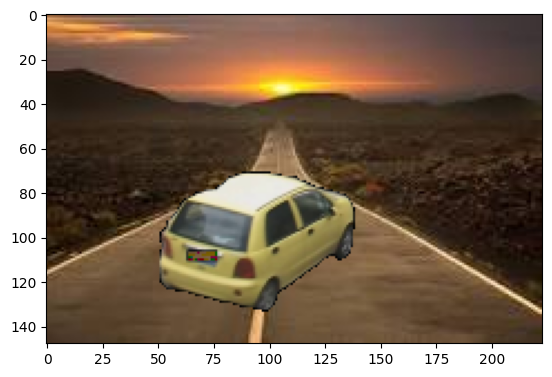

In [11]:
temp_road = road.copy()
temp_mask = only_car_resized == 0
modified_temp_road = temp_road[70:70+only_car_resized.shape[0], 50:50+only_car_resized.shape[1]] * temp_mask
temp_road[70:70+only_car_resized.shape[0], 50:50+only_car_resized.shape[1]] =modified_temp_road + only_car_resized
plt.imshow(temp_road)